# Understand-Clean-Visualize-Train Model

**Imports**

In [1]:
# data manipulation libraries
import pandas as pd
import numpy as np
# pd.set_option('display.max_columns', 60)

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
#to enable high resolution plots

# feature extraction and preprocessing
import re
import datetime
from sklearn.model_selection import train_test_split

# models 
import xgboost as xgb
from collections import Counter

# metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score
import shap


# to bypass warnings in section 2.5.
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

**Functions to use in Parts 1 & 2**

In [2]:
# Section 1 Understand & Format & Clean Data functions
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent],
                              axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1))

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# Section 2 Exploratory Data Analysis Functions


def plot_histogram(df, column, b=None):
    # funtion to print histogram
    # with mean and median
    # using distplot

    # set the histogram, mean and median
    g = sns.distplot(df[column],
                     kde=False,
                     bins=b)
    plt.axvline(x=df[column].mean(),
                linewidth=3,
                color='g',
                label="mean",
                alpha=0.5)
    plt.axvline(x=df[column].median(),
                linewidth=3,
                color='y',
                label="median",
                alpha=0.5)

    # set title, legends and labels
    plt.xlabel("{}".format(column),
               size=14)
    plt.ylabel("Count",
               size=14)
    plt.title("Distribution of {}".format(column),
              size=16)
    plt.legend(["mean", "median"])

    return g


def plot_distribution(df, target, column_values, column_name):
    # funtion to print distribution of a continuous variable
    # for categorical data

    for value in column_values:
        subset = df[
            df[column_name] == value]
        g = sns.kdeplot(subset[target],
                        label=value,
                        linewidth=3)

    # set title, legends and labels
    plt.ylabel("Density",
               size=14)
    plt.xlabel("{}".format(target),
               size=14)
    plt.title("Distribution of {} per {}"
              .format(target, column_name),
              size=16)

    return g


def create_province_list(df, country_name):
    # funtion to create list of provinces
    # for a given country name
    indexed_train = df.set_index("country")
    province_list = list(
        indexed_train
        .loc[country_name]["province"]
        .unique())
    return province_list

# Understand, Clean and Format Data

In [3]:
df = pd.read_csv('dataset.csv', index_col=0)

In [4]:
df

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X144,X145,X146,X147,X148,X149,X150,X151,X152,Class
0,65,22,216,0.749175,0.000000,0.625455,0.092437,2,10,204,...,4,4,9,4,4,2,2,3,2,1.0
1,49,19,399,0.533191,0.044968,0.530667,0.045455,2,30,367,...,8,2,7,8,2,3,4,1,4,1.0
2,59,34,154,0.785425,0.044534,0.669903,0.180851,0,14,140,...,3,4,3,3,9,4,2,2,4,0.0
3,56,73,19,1.000000,0.000000,0.437500,0.793478,0,1,18,...,2,2,2,2,2,2,1,1,1,1.0
4,69,48,172,0.844291,0.010381,0.509579,0.218182,1,14,157,...,2,3,3,3,2,2,2,2,6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,73,31,384,0.719262,0.022541,0.523697,0.074699,1,16,367,...,4,2,4,4,4,2,4,2,2,0.0
249,67,43,149,0.810811,0.011583,0.534483,0.223958,0,17,132,...,2,3,4,4,4,2,3,1,2,0.0
250,29,6,134,0.834320,0.000000,0.454545,0.042857,0,17,117,...,2,3,4,4,4,3,2,3,3,0.0
251,17,4,217,0.638655,0.012605,0.634146,0.018100,0,14,203,...,2,4,4,4,5,3,3,1,3,NaN


### Check the target proportions

In [5]:
df.Class.value_counts()

0.0    119
1.0    100
Name: Class, dtype: int64

Target ratio is close to 40:60 which means that the dataset is only slightly biased. However, the difference is 19 records only meaning that there is no need to deal with those poportions. 

### Descriptive statistics & information about datasets 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253 entries, 0 to 252
Columns: 154 entries, X0 to Class
dtypes: float64(57), int64(97)
memory usage: 306.4 KB


There are only numerical features.

In [7]:
df.describe()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X144,X145,X146,X147,X148,X149,X150,X151,X152,Class
count,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,...,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.00000,253.000000,253.000000,219.000000
mean,83.169960,41.300395,230.569170,0.778326,0.028182,0.542441,0.205438,0.529644,14.743083,215.296443,...,2.873518,2.869565,3.521739,3.944664,4.284585,2.264822,2.12253,2.213439,2.335968,0.456621
std,43.812538,30.280905,146.341117,0.171685,0.037504,0.076312,0.186400,0.910755,11.623782,138.762970,...,1.256653,1.216121,1.473483,1.698769,2.183551,0.857407,1.02972,1.120647,0.926768,0.499256
min,5.000000,2.000000,11.000000,0.257679,0.000000,0.410714,0.006689,0.000000,0.000000,8.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.00000,1.000000,1.000000,0.000000
25%,52.000000,18.000000,107.000000,0.694915,0.000000,0.494553,0.065753,0.000000,6.000000,100.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,2.000000,1.00000,1.000000,2.000000,0.000000
50%,75.000000,32.000000,232.000000,0.796339,0.011976,0.526132,0.122112,0.000000,12.000000,214.000000,...,2.000000,3.000000,3.000000,4.000000,4.000000,2.000000,2.00000,2.000000,2.000000,0.000000
75%,108.000000,62.000000,322.000000,0.924686,0.042763,0.570370,0.315615,1.000000,20.000000,303.000000,...,4.000000,4.000000,4.000000,5.000000,5.000000,3.000000,3.00000,3.000000,3.000000,1.000000
max,245.000000,148.000000,950.000000,1.000000,0.165842,0.898067,0.793478,7.000000,97.000000,851.000000,...,8.000000,11.000000,9.000000,10.000000,16.000000,6.000000,8.00000,6.000000,6.000000,1.000000


### Description of features and target

In [8]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X144,X145,X146,X147,X148,X149,X150,X151,X152,Class
0,65,22,216,0.749175,0.000000,0.625455,0.092437,2,10,204,...,4,4,9,4,4,2,2,3,2,1.0
1,49,19,399,0.533191,0.044968,0.530667,0.045455,2,30,367,...,8,2,7,8,2,3,4,1,4,1.0
2,59,34,154,0.785425,0.044534,0.669903,0.180851,0,14,140,...,3,4,3,3,9,4,2,2,4,0.0
3,56,73,19,1.000000,0.000000,0.437500,0.793478,0,1,18,...,2,2,2,2,2,2,1,1,1,1.0
4,69,48,172,0.844291,0.010381,0.509579,0.218182,1,14,157,...,2,3,3,3,2,2,2,2,6,1.0


In [9]:
df.sample(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X144,X145,X146,X147,X148,X149,X150,X151,X152,Class
226,69,23,227,0.736677,0.012539,0.567010,0.092000,0,16,211,...,5,3,6,5,4,3,2,4,3,1.0
53,66,19,226,0.752412,0.000000,0.526132,0.077551,0,5,221,...,3,3,6,3,7,2,2,3,2,1.0
8,129,109,91,0.981763,0.000000,0.477273,0.545000,0,15,76,...,2,1,2,2,4,1,1,2,1,1.0
94,107,34,324,0.821505,0.002151,0.527964,0.094972,1,25,298,...,4,2,5,5,3,3,2,2,3,NaN
90,72,20,256,0.752874,0.002874,0.546547,0.072464,0,14,242,...,6,1,4,5,6,2,2,3,2,0.0


### Check for duplicates

In [10]:
# Selecting duplicate rows except first
# occurrence based on all columns
duplicate = df[df.duplicated()]
 
print("Duplicate Rows :")
 
# Print the resultant Dataframe
duplicate

Duplicate Rows :


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X144,X145,X146,X147,X148,X149,X150,X151,X152,Class


No duplicate rows.

### Missing values of the datasets

In [11]:
missing_values_table(df)

Your selected dataframe has 154 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Class,34,13.4


The only feature with missing values is the target class which has overall 13.4% missing values. In order to avoid bias and target leakage in final model, I'm not going to use data with missing target in training. However, I'm going to keep it for evaluation purposes.

In [12]:
df[df['Class'].isna()]

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X144,X145,X146,X147,X148,X149,X150,X151,X152,Class
5,70,32,263,0.736986,0.002740,0.536657,0.108475,1,24,238,...,2,3,6,4,5,2,2,1,2,NaN
17,89,71,65,0.968889,0.004444,0.473684,0.522059,0,1,64,...,2,2,2,2,2,1,1,1,1,NaN
23,75,39,306,0.704762,0.085714,0.580838,0.113043,0,18,288,...,3,2,4,4,3,2,2,2,2,NaN
29,75,28,226,0.729483,0.012158,0.685811,0.110236,0,24,202,...,2,4,4,4,3,2,2,4,2,NaN
69,118,51,317,0.845679,0.002058,0.507495,0.138587,2,11,304,...,2,3,2,4,5,2,1,4,2,NaN
87,85,26,240,0.752137,0.108262,0.526490,0.097744,1,9,230,...,4,3,3,4,4,2,2,3,2,NaN
94,107,34,324,0.821505,0.002151,0.527964,0.094972,1,25,298,...,4,2,5,5,3,3,2,2,3,NaN
124,41,3,71,0.895652,0.000000,0.623853,0.040541,0,5,66,...,2,4,4,4,3,2,2,2,2,NaN
145,106,48,222,0.853723,0.010638,0.509859,0.177778,0,11,211,...,3,3,4,5,4,2,2,3,2,NaN
148,60,8,37,1.000000,0.000000,0.657143,0.177778,0,5,32,...,2,2,2,2,2,2,2,2,2,NaN


### Correlation matrix of features
Just for the sake of clarity I'm going to compare correlation matrix of all features and data and all features and only these rows which target is NaN. With this, I am checking if there are no strong correlations between data and the target. This may help me with avoiding target leakage or help me with imputting missing target values if there is a strong correlation.

<AxesSubplot:>

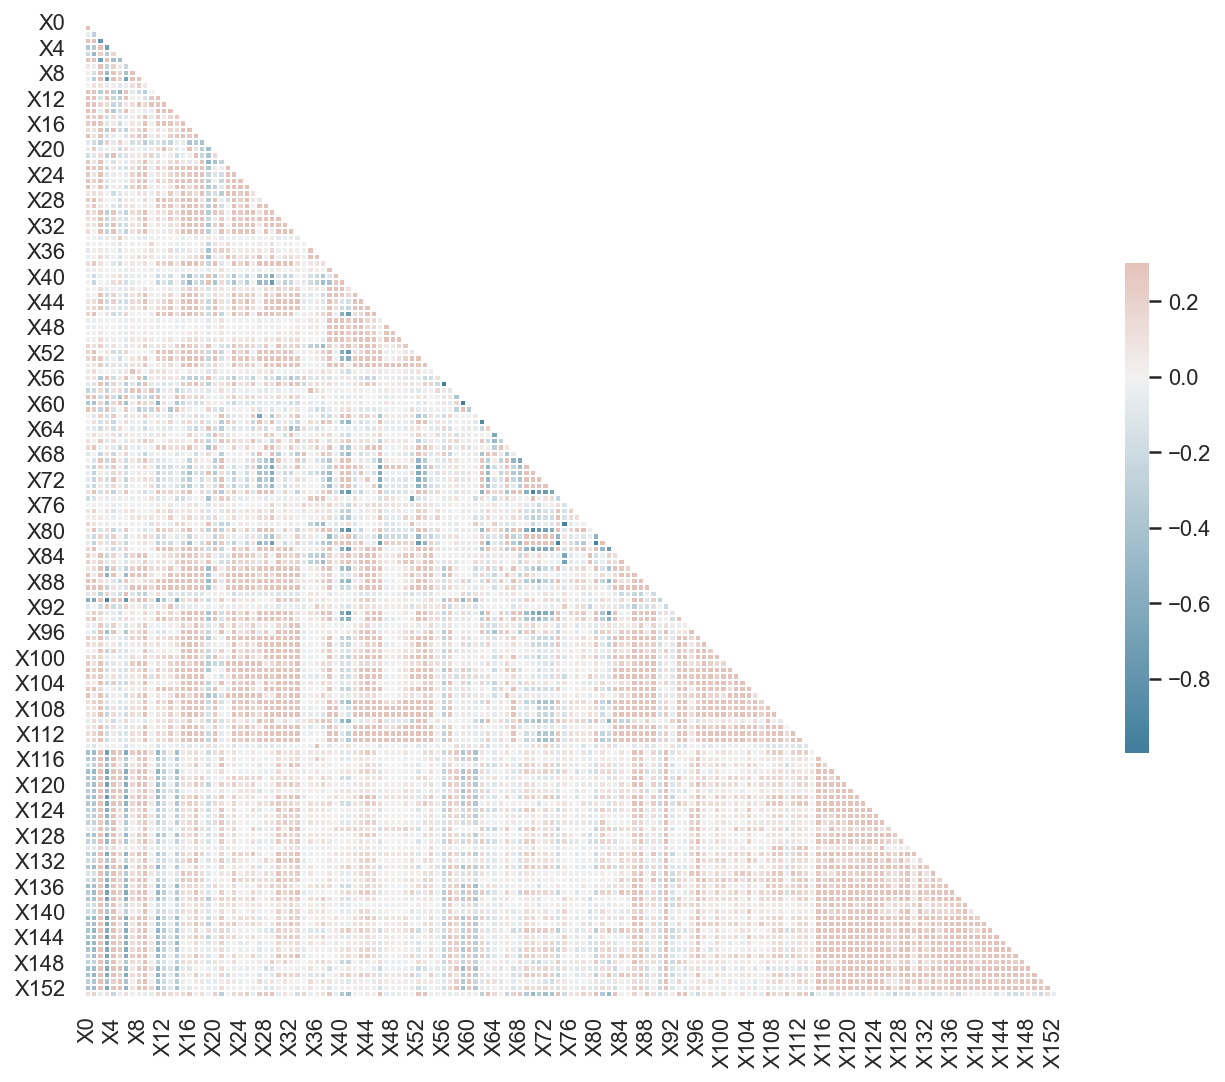

In [13]:
sns.set_theme(style="white")
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


<AxesSubplot:>

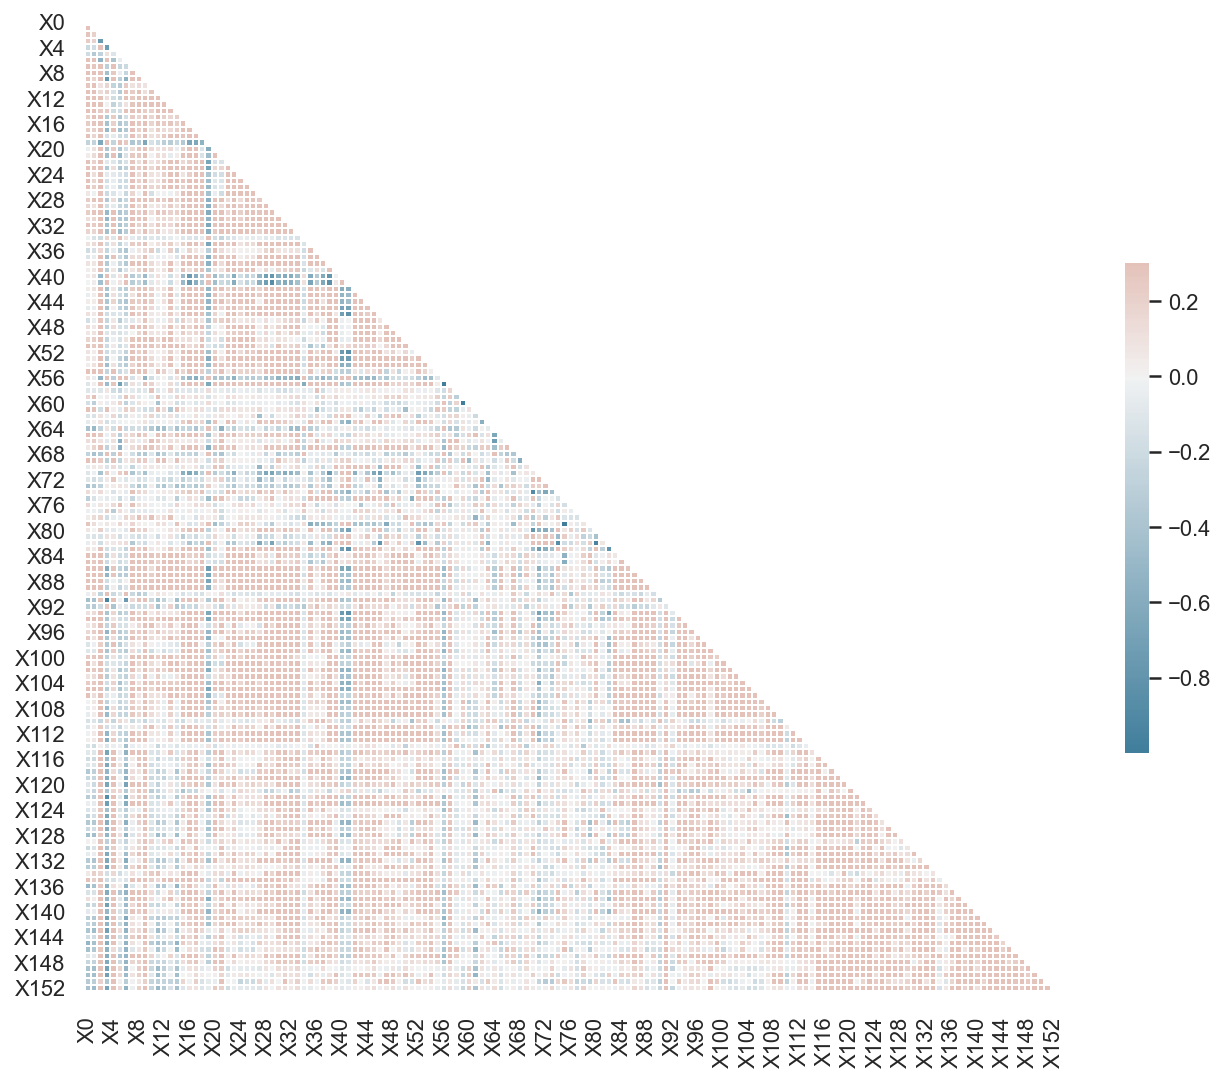

In [14]:
sns.set_theme(style="white")
# Compute the correlation matrix
corr = df[df['Class'].isna()].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


Even though the above matrixes are not very readable with that many features, it is obvious there is no strong correlation between features. 

### Take out rows with missing target

In [15]:
missing_target = df[df['Class'].isna()]

Now drop missing values from a dataset

In [16]:
df = df.dropna(subset=['Class'])

In [17]:
missing_values_table(df)

Your selected dataframe has 154 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### Split data
I'm going to randomly split data, and use 80% of data to train the model and 20% to test it.

In [18]:
train, test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=RANDOM_STATE)

In [19]:
print("There are {} rows and {} columns in the train dataset."
      .format(train.shape[0], train.shape[1]))

There are 175 rows and 154 columns in the train dataset.


In [20]:
print("There are {} rows and {} columns in the test dataset."
      .format(test.shape[0], test.shape[1]))

There are 44 rows and 154 columns in the test dataset.


Train dataset is the dataset that I'm are going to build a model on, test dataset will be used for evaluation.

# Exploratory Data Analysis

### Distribution of X1

<AxesSubplot:title={'center':'Distribution of X1'}, xlabel='X1', ylabel='Count'>

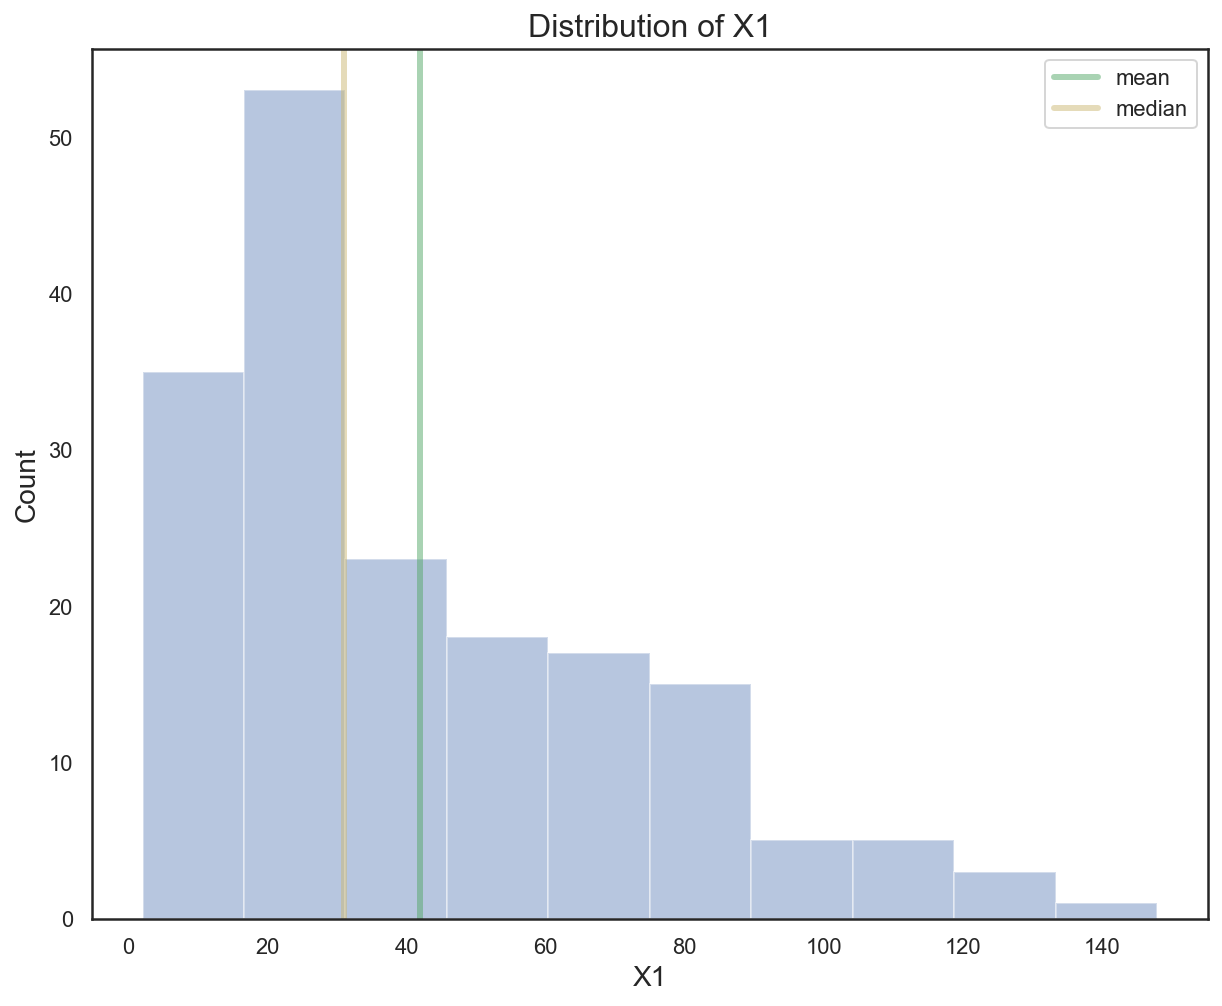

In [21]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train, "X1")

### Distribution of X140

<AxesSubplot:title={'center':'Distribution of X140'}, xlabel='X140', ylabel='Count'>

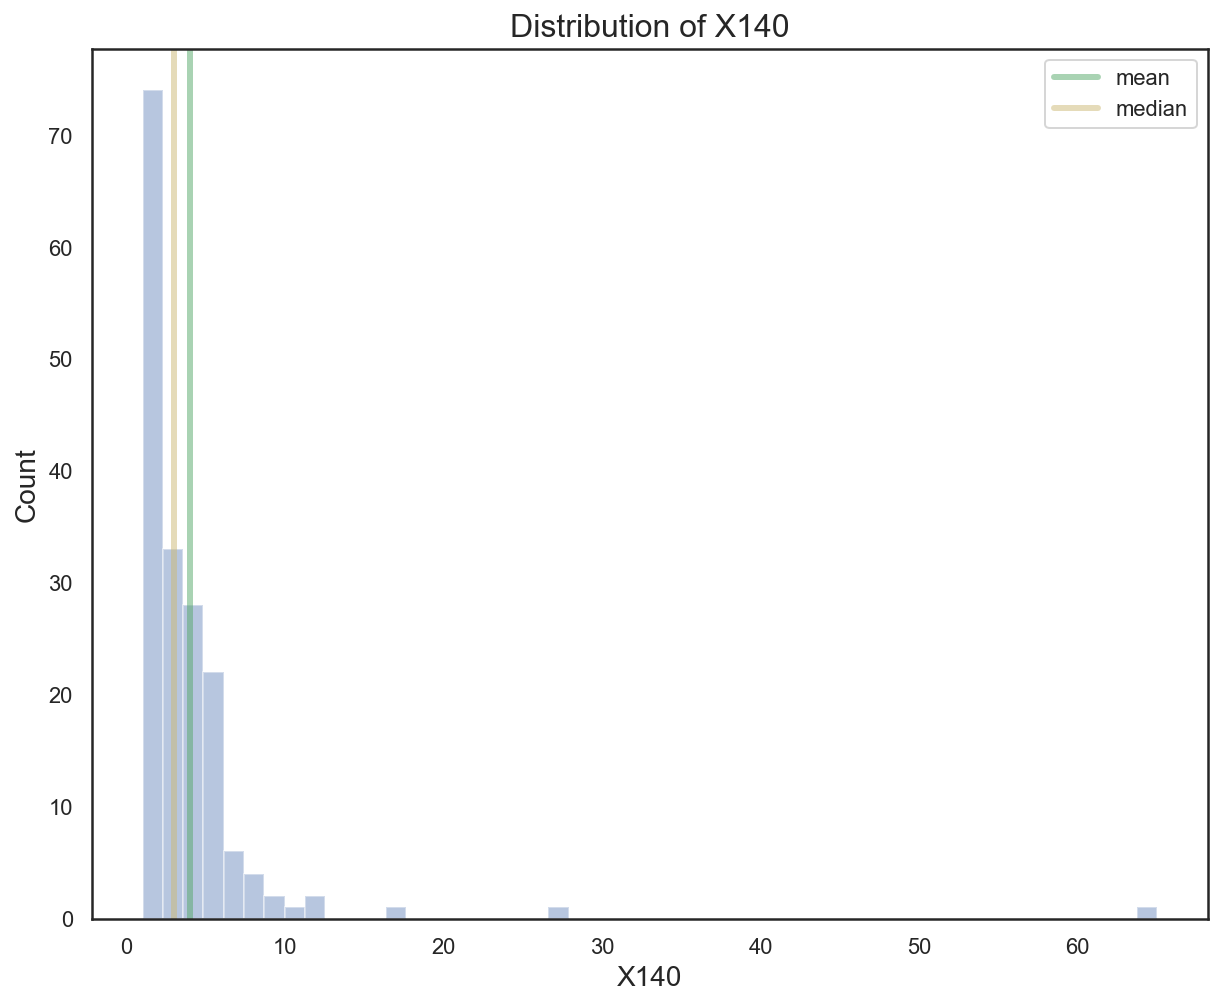

In [22]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train, "X140")

(0.0, 200.0)

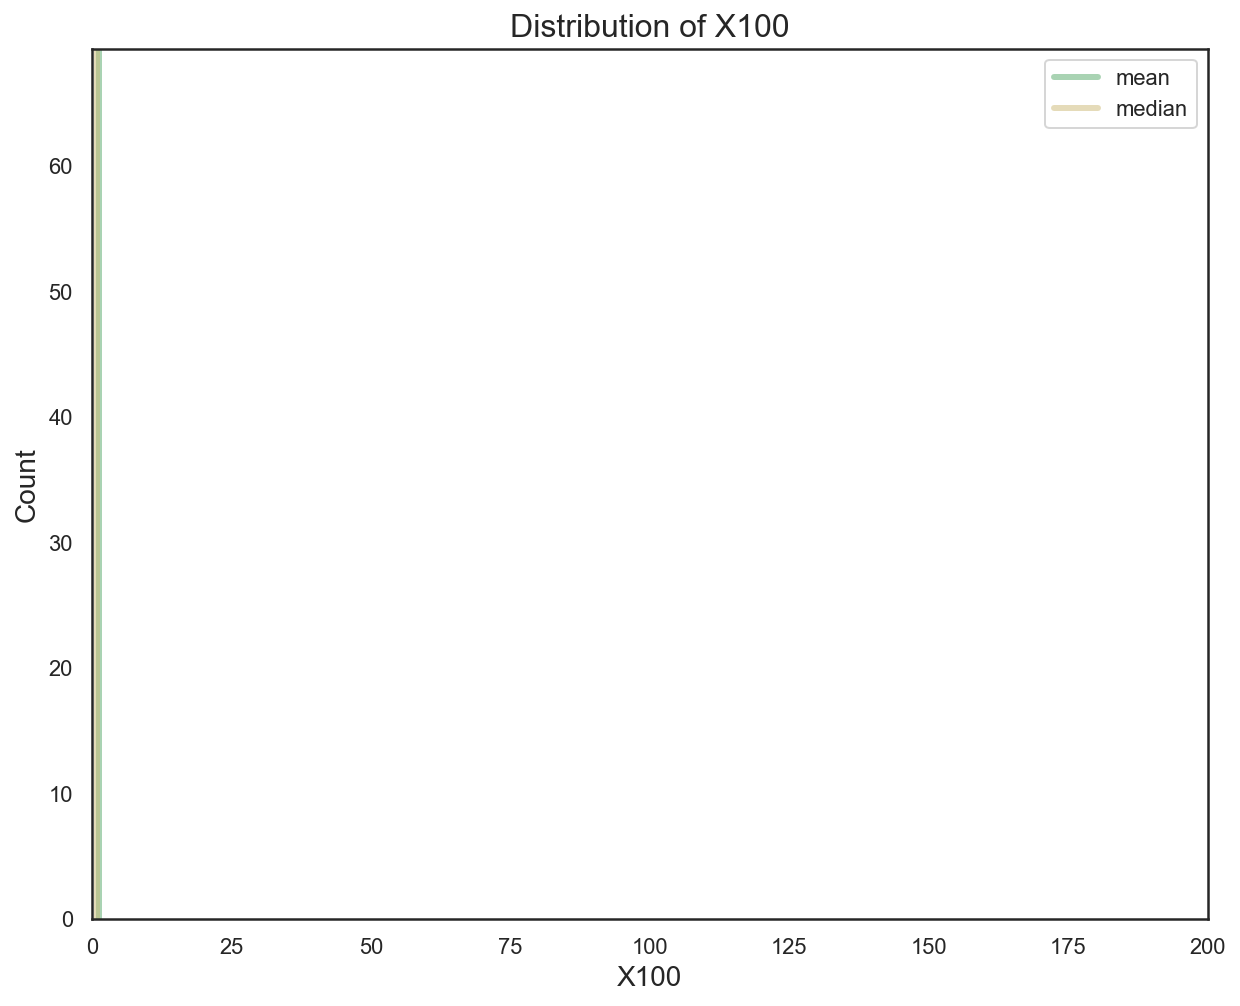

In [23]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train, "X100", 200)
plt.xlim(0,200)
# plt.savefig("PriceDistribution.png")

### Findings from exploratory data analysis

As the target is not defined and variables seem to be randomly generated, there is no point in performing further data exploration. 

One finding from the above histograms is that it may be worth to encode features as their value ranges vary.

## Feature Engineering

This particular dataset does not require feature engineering as there is no categorical data, no missing values, etc.
I am only going to create vlidation set out of the training set. 

### Training and validation split

In [24]:
X_train = train.drop('Class', axis=1)
y_train = train['Class']

X_test = test.drop('Class', axis=1)
y_test = test['Class']

In [25]:
# # create validaiton set
# X_train, X_valid, y_train, y_valid = train_test_split(
#     train_features, 
#     train_target, 
#     test_size=0.25, 
#     random_state=42)

# Modelling

### Calculate proportion of the positive class to negative class
Will help to set weights for the model and avoid bias. 

In [26]:
# count examples in each class
counter = Counter(y_train)
#estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.134


## XGBoost
I'm going to use XGBoost classifier from the family of Gradient Boosting models which are state of the art for this kind of problems nowadays.

In [27]:
# The model seem to perform better with default parameters.
model_params = {
#              'colsample_bytree': 0.9515417999403323,
#              'learning_rate': 0.1957242273064083,
#              'max_depth': 4,
#              'min_child_weight': 56,
#              'n_estimators': 500,
#              'reg_alpha': 5.30835818495344,
#              'reg_lambda': 0.02100329573229573,
             'scale_pos_weight': 1.079, # threshold calculated above
#              'subsample': 0.9206599128150947
        }
        
model = xgb.XGBClassifier(**model_params, random_state=21, use_label_encoder=False, tree_method="hist", verbosity=0, enable_categorical=True) #**model_params, 
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=21, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1.079, subsample=1, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [28]:
y_pred_proba_valid = model.predict_proba(X_test)

In [29]:
y_pred = model.predict(X_test)

In [30]:
y_test.value_counts()

0.0    26
1.0    18
Name: Class, dtype: int64

Collective performance metrics

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81        26
         1.0       0.72      0.72      0.72        18

    accuracy                           0.77        44
   macro avg       0.76      0.76      0.76        44
weighted avg       0.77      0.77      0.77        44



ROC AUC score

In [32]:
roc_auc_score(y_test, y_pred_proba_valid[:, 1])

0.8397435897435896

### Feature importances

In [33]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

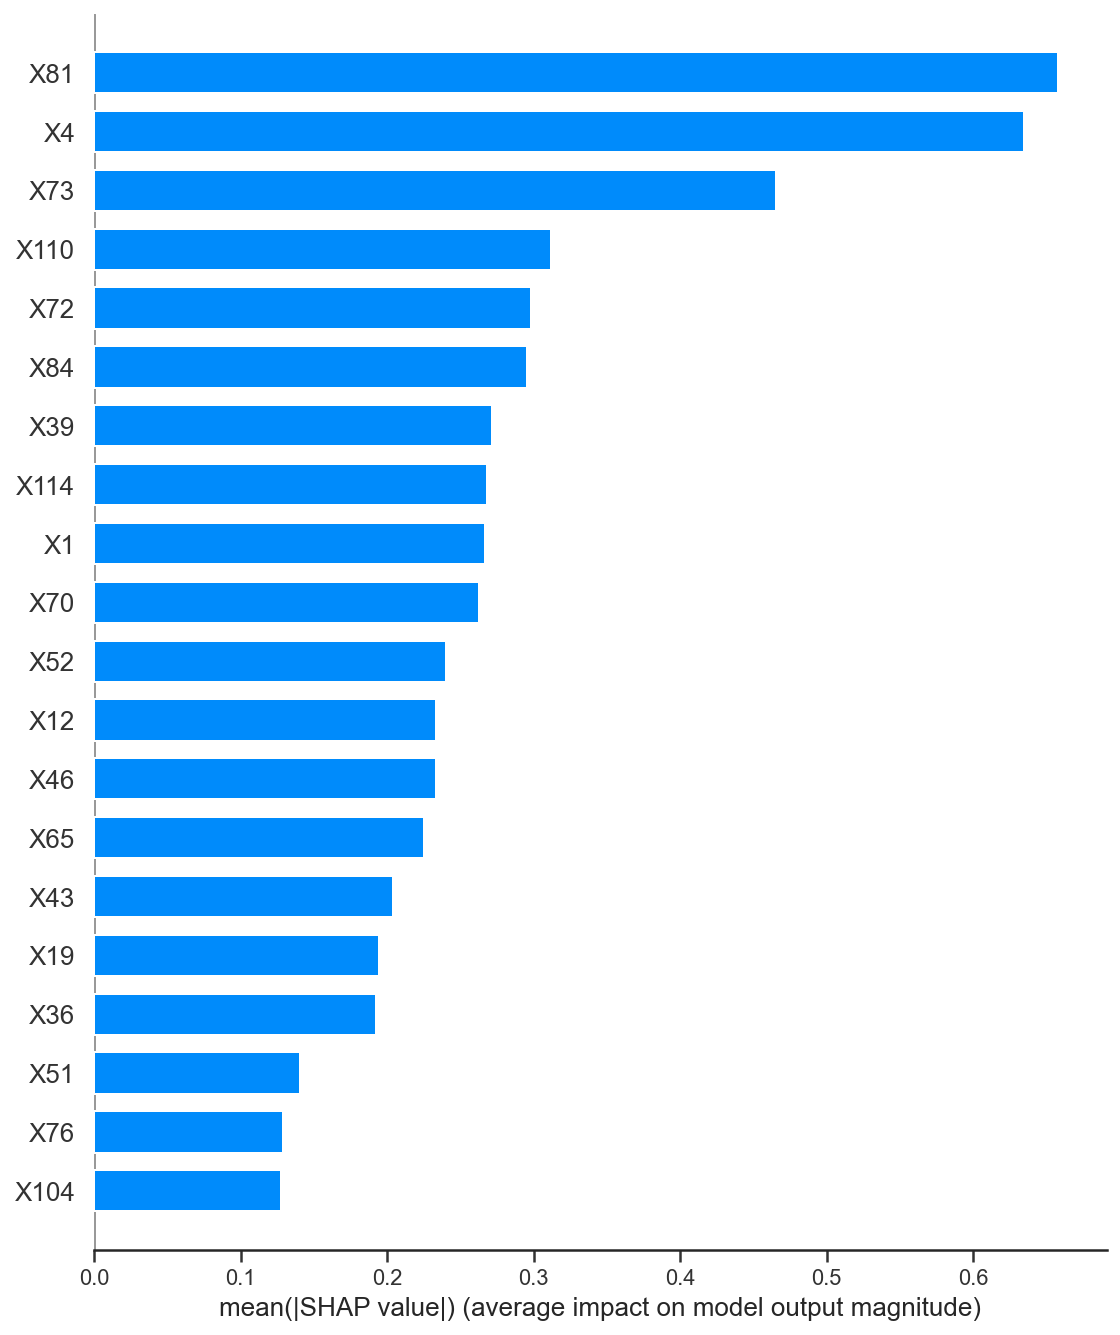

In [34]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Features X81, X4 and X73 are with high importance for model predictions. It may be worth to investigate if these features do not cause target leakage. 

### Precision vs Recall

In [35]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_valid[:, 1])

In [36]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

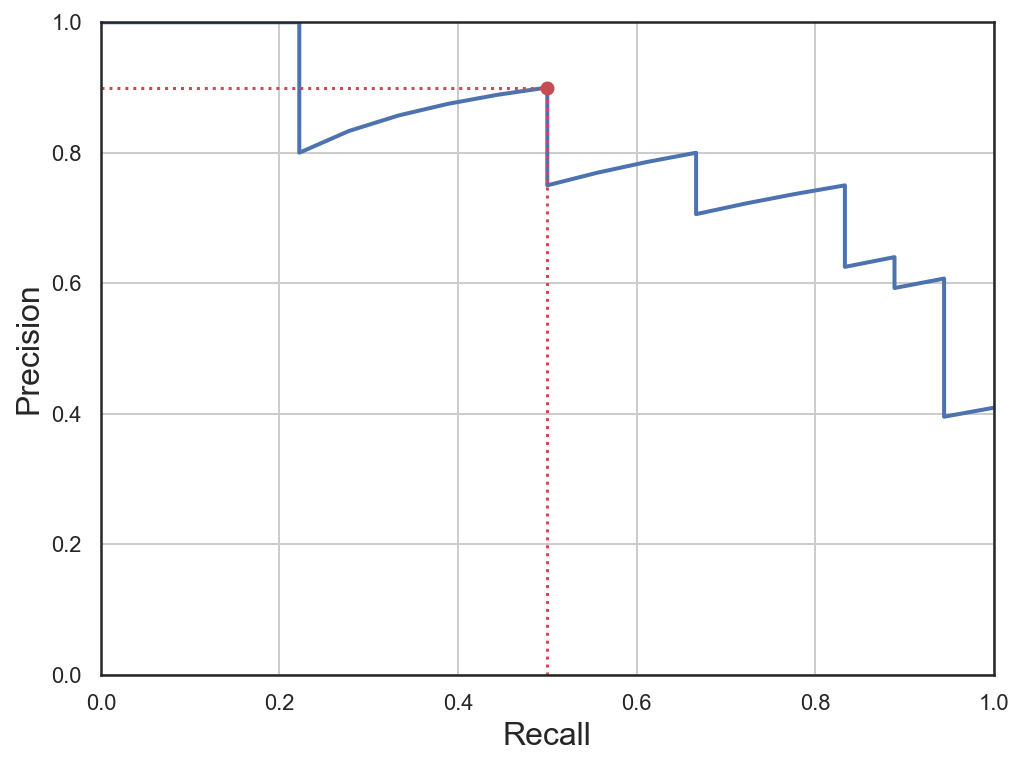

In [37]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
# save_fig("precision_vs_recall_plot")
plt.show()

### ROC Curve

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_valid[:, 1])

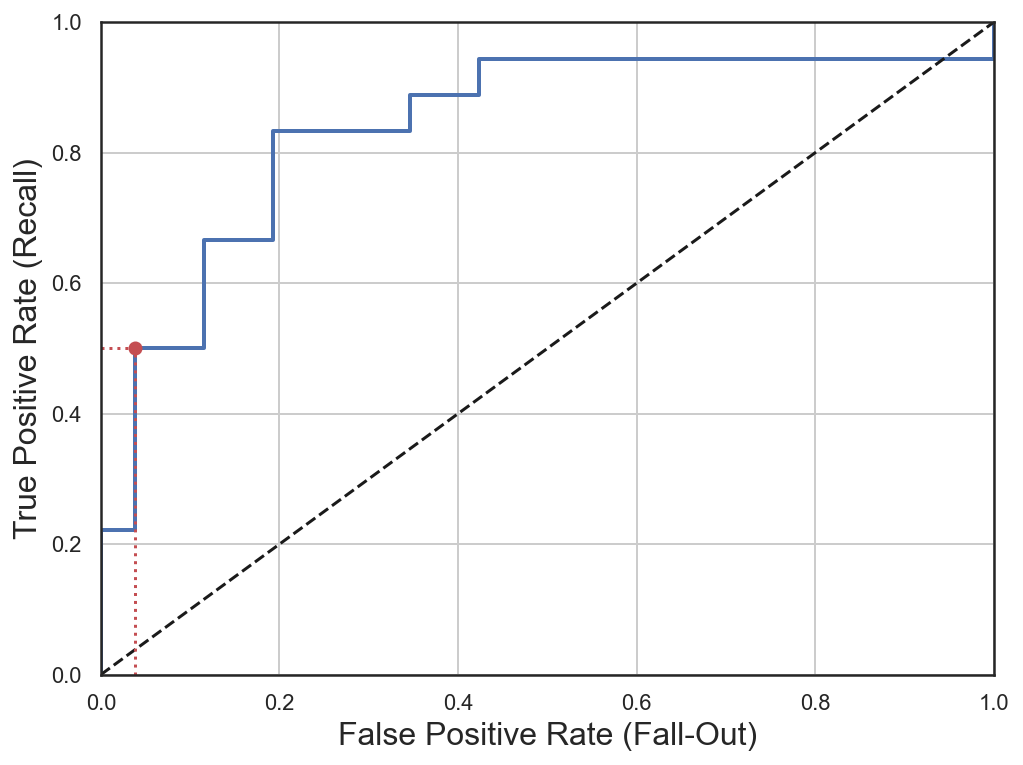

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                 
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                  
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")  
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
# save_fig("roc_curve_plot")                                   
plt.show()

The above plots look so "sharp" because of the very few testing instances. 

### Findings from modeling
It is difficult to asses model performance given so little data.

Model will most probably be to simple to be effective on production data. This is because of the to little traing data.

# Save Model

In [44]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=21, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1.079, subsample=1, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [45]:
from joblib import dump
dump(model, 'XGB_model.joblib')

['XGB_model.joblib']